In [13]:
import torch
import torch.nn.functional as F

from torch_geometric.data import Data, DataLoader, InMemoryDataset
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T

import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, trange
from IPython.display import clear_output
from typing import Literal

torch.cuda.is_available()

True

In [14]:
from Encoding import GetEdgeIdx, Encoding
class DEM_Dataset(InMemoryDataset):
    def __init__(self,file_name: str,data_split,
                 Dataset_type: Literal["train","validate","test"],
                 mode: Literal["cart","delta"],
                 root: str = os.getcwd()+r"\Data", 
                 force_reload=False,transform=None, pre_transform=None, pre_filter=None):
        
        self.raw_data_path = f"{root}\\raw"
        self.processed_data_path = f"{root}\\processed"
        self.file_name = file_name
        self.Dataset_type = Dataset_type
        self.mode = mode
        self.data_split = data_split
        super().__init__(root, transform, pre_transform,pre_filter,force_reload=force_reload)
        self.load(os.path.join(self.processed_data_path,self.processed_file_names[0]))

    @property 
    def raw_file_names(self):
        return[f"{self.file_name}_Data.npy",
               f"{self.file_name}_Topology.npy",
               f"{self.file_name}_BC.npy"]
    
    @property
    def processed_file_names(self):
        if self.pre_filter is None: return [f"{self.file_name}_{self.mode}_{self.Dataset_type}.pt"]
        else: return [f"{self.file_name}_{self.mode}_{self.Dataset_type}_init.pt"]
    
    def download(self):
        pass
    
    # Load data and split them according to dataset split
    def LoadSimTop(self,i):
        data = np.load(f"{self.raw_data_path}\\{self.raw_file_names[i]}",allow_pickle=True)
        Daset_type_idx = {"train":0,"validate":1,"test":2}[self.Dataset_type]
        splits=np.array(self.data_split)*data.shape[0]
        return np.split(data,splits.astype(int))[Daset_type_idx]

    def process(self):
        data_list = []
        data_agr,top_agr,bc= [self.LoadSimTop(i) for i in [0,1,2]]
        simulations,topologies = Encoding(data_agr,top_agr,bc)
            
        if self.pre_filter is not None:
            simulations = self.pre_filter(simulations)

        for sim, top in tqdm(zip(simulations,topologies)):
            for t in np.arange(len(sim)-1):
                real_idx = sim[t][:,-1:].squeeze().nonzero()
                maskx = np.squeeze(sim[t][:,-1:]==1)
                x = torch.tensor(sim[t],dtype=torch.float)
                
                y_abs = torch.tensor(sim[t+1][real_idx,:3],dtype=torch.float).squeeze()
                if self.mode == 'cart':     y = y_abs    
                if self.mode == 'delta':    y = y_abs-x[maskx,:3]
                    
                edge_index = GetEdgeIdx(top[t],real_idx) 
                data = Data(pos=x[:,:3],x=x[:,3:],y=y,edge_index=edge_index,mask=maskx,time=t)
                data_list.append(data)

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]        
                
        self.save(data_list, os.path.join(self.processed_data_path,self.processed_file_names[0]))

In [15]:
class RelPosConv(MessagePassing):
    def __init__(self, emb_dim, msg_dim, out_channels, aggr = 'mean'):
        super().__init__(aggr=aggr)
        self.edge_mlp = torch.nn.Linear(emb_dim+emb_dim,msg_dim)
        self.update_mlp = torch.nn.Linear(emb_dim+msg_dim,out_channels)
        self.reset_parameters()

    def forward(self,x,edge_attr,edge_index):
        out = self.propagate(edge_index,x=x,edge_attr=edge_attr)
        return out
    
    def message(self, x_j, edge_attr):
        tmp = torch.cat([x_j, edge_attr],dim=1)
        return self.edge_mlp(tmp)
    
    def update(self,aggr_out,x):
        cat = torch.cat([x, aggr_out],dim=1)
        return self.update_mlp(cat)

In [16]:
class GCONV_Model_RelPos(torch.nn.Module):
    def __init__(self, emb_dim=64, msg_dim=64, node_dim=7, edge_dim=4, out_dim = 3):
        super(GCONV_Model_RelPos,self).__init__()
        self.node_embed = torch.nn.Linear(node_dim,emb_dim)
        self.edge_embed = torch.nn.Linear(edge_dim,emb_dim)
        self.conv1 = RelPosConv(emb_dim,msg_dim,emb_dim)
        self.conv2 = RelPosConv(emb_dim,msg_dim,emb_dim)
        self.conv3 = RelPosConv(emb_dim,msg_dim,out_dim)
        self.mode = "delta"

    def forward(self,data):
        x, edge_attr, edge_index = data.x, data.edge_attr, data.edge_index
        x = self.node_embed(x)
        edge_attr = self.edge_embed(edge_attr)
        x = F.relu(x)
        x = self.conv1(x, edge_attr, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_attr, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_attr, edge_index)
        return x

In [17]:
class Trainer:
    def __init__(self,model,dataset_train,dataset_val,batch_size,lr,epochs,model_name,loss_fn=torch.nn.MSELoss()):
        self.model = model
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.loss_fn = loss_fn
        self.model_name = model_name

        self.device = torch.device('cuda' if torch.cuda.is_available()else 'cpu')
        print("Device: ", self.device)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=self.lr)
        self.train_dl = self.make_data_loader(dataset_train, shuffle=True)
        self.val_dl = self.make_data_loader(dataset_val, shuffle=False)

    def make_data_loader(self, dataset, shuffle):
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=shuffle)
    
    def loss_batch(self, batch,opt=None):
        out = self.model(batch)
        mask = np.concatenate(batch.mask)
        loss =self.loss_fn(out[mask], batch.y)

        if opt is not None:
            loss.backward()
            opt.step()
            opt.zero_grad()
        return loss.item()

    def batch_loop(self, dataloader, loss_list, axes, opt=None):
        mean_loss = 0
        for i, batch in enumerate(dataloader):
            batch_loss = self.loss_batch(batch.to(self.device), opt)
            mean_loss += batch_loss
        mean_loss /= i
        loss_list.append(mean_loss)
        axes[0].plot(loss_list)
        axes[1].plot(loss_list[-5:])
        return mean_loss,loss_list

    def train_loop(self):
        train_loss, val_loss = [], []
        best_model_loss = np.inf
        for epoch in tqdm(range(self.epochs)):
            clear_output(wait=True)
            fig, axes = plt.subplots(1,2)
            fig.set_figwidth(15)

            self.model.train()  
            mean_train_loss, train_loss = self.batch_loop(self.train_dl,train_loss,axes,self.optimizer)

            self.model.eval()
            with torch.inference_mode():
                mean_val_loss, val_loss = self.batch_loop(self.val_dl,val_loss,axes)

            for ax in axes: ax.set(xlabel='Epoch',ylabel='Loss'), ax.set_ylim(ymin=0), ax.set_xlim(xmin=0)

            plt.show()

            if mean_val_loss < best_model_loss:
                best_model_loss = mean_val_loss
                torch.save(self.model.state_dict(),os.path.join(os.getcwd(),"Models",self.model_name))

            print(f"Epoch {epoch}, Mean Train Loss: {mean_train_loss}, Mean Validation Loss: {mean_val_loss}")
        np.save(f"{os.getcwd()}\\Models\\{self.model_name}_Training_Loss",train_loss)
        np.save(f"{os.getcwd()}\\Models\\{self.model_name}_Validation_Loss",val_loss)

In [18]:
def GetModel(dataset_name,model_name,edge_dim):
    model = GCONV_Model_RelPos(edge_dim=edge_dim)
    try: model.load_state_dict(torch.load(f"{os.getcwd()}\\Models\\{dataset_name}_GCONV_Model_{model_name}"))
    except: print("No Trained model")
    return model

In [19]:
transform_norm = T.Compose([T.NormalizeScale(),T.Cartesian(False)])
transform_eq = T.Cartesian(False)
transform_dist = T.Compose([T.Cartesian(False), T.Distance(norm=False,cat=True)])

file_name="N400"
data_split=[0.85, 0.95]
transform = transform_dist
force_reload = False
train = False

if train == True:
    dataset_train     = DEM_Dataset(file_name, data_split,"train"   ,'delta', pre_transform=transform,force_reload=force_reload)
    dataset_val       = DEM_Dataset(file_name, data_split,"validate",'delta', pre_transform=transform,force_reload=force_reload)
    dataset_test      = DEM_Dataset(file_name, data_split,"test"    ,'delta', pre_transform=transform,force_reload=force_reload)

    model = GetModel("N400","RelPos_03",edge_dim=4)
    trainer = Trainer(model, dataset_train,dataset_val,
                    batch_size=64,
                    lr=0.00000001,
                    epochs=2000,
                    model_name=f"{file_name}_GCONV_Model_RelPos_03")
    trainer.train_loop()

In [20]:
def FilterStart(dataset):
    idx = np.nonzero([data.time == 0 for data in dataset])
    return torch.utils.data.Subset(dataset_test,idx)[0]

#dataset_test_start = FilterStart(dataset_test)

In [21]:
from Encoding import ToPytorchData, GetLength

def GetLimits(data):
    max = [torch.max(data.x[:,i]) for i in [0, 1, 2]]
    min = [torch.min(data.x[:,i]) for i in [0, 1, 2]]
    max = torch.stack(max)
    min = torch.stack(min)
    limits = torch.stack([min,max],dim=1)
    return limits


In [22]:
class LearnedSimulator:
    def BCrollout(self):
        print("Calculating BC")
        BC_rollout = np.empty((GetLength(self.par_data),6,9))
        BC_t=np.copy(self.BC)
        for t in trange(GetLength(self.par_data)):
            BC_t[:,:3] = self.BC[:,:3]+(t+1)*self.BC[:,-3:] 
            BC_rollout[t] = BC_t
        return BC_rollout
    
    def GroundTruth_Rollout(self):
        print("Collecting Ground Truth Rollout")
        GroundTruth = np.empty(GetLength(self.par_data),dtype=object)
        for t in trange(GetLength(self.par_data)):
            data = ToPytorchData(self.par_data[t],self.BC_rollout[t],self.tol,self.topology[t])[0]
            GroundTruth[t] = data
        return GroundTruth
    
    def MLRollout(self):
        print("Calculating Learned Rollout")
        with torch.inference_mode():
            
            ML_Rollout = np.empty((self.timesteps),dtype=object)
            par_inp = self.par_data[0]
            ML_Rollout[0] = ToPytorchData(par_inp,self.BC_rollout[0],self.tol)[0]

            for t in tqdm(range(1,self.timesteps)):
                input_data, MatlabTopology = ToPytorchData(par_inp,self.BC_rollout[t],self.tol)
                if self.model.mode == 'delta': 
                    transform = T.Compose([T.Cartesian(False), T.Distance(norm=False,cat=True)])
                    #transform = T.Cartesian(False)
                input_data.to(self.device)

                output = self.model(transform(input_data))
                par_inp[:,:3] = par_inp[:,:3]+output[input_data.mask].cpu().numpy()
                output_data = ToPytorchData(par_inp,self.BC_rollout[t],self.tol,MatlabTopology)
                ML_Rollout[t] = output_data[0]
        return ML_Rollout
    
    def __init__(self,model,data_agr, top_agr,BC_agr,i: int,tol,timesteps=100):
        self.device = torch.device('cuda' if torch.cuda.is_available()else 'cpu')
        self.BC = BC_agr[i]
        self.par_data = data_agr[i]
        self.topology = top_agr[i]
        self.model = model.to(self.device)
        self.data_list = []
        self.timesteps = timesteps
        self.tol = tol
        self.BC_rollout = self.BCrollout()
        self.GroundTruth = self.GroundTruth_Rollout()
        self.ML_rollout = self.MLRollout()

In [23]:
from Encoding import load

dataset_name = "N400"
model_name = "RelPos_02"
model = GetModel(dataset_name,model_name,edge_dim=4)
AggregatedArgs = load(dataset_name)
Rollout = LearnedSimulator(model,*AggregatedArgs,i=0,tol=0,timesteps=100)

No Trained model
Calculating BC


100%|██████████| 100/100 [00:00<00:00, 99816.85it/s]


100%|██████████| 100/100 [00:00<00:00, 1562.55it/s]

Calculating Learned Rollout



100%|██████████| 99/99 [00:40<00:00,  2.47it/s]


In [25]:
from Plotting import GetInternalStressRollout
stress = GetInternalStressRollout(Rollout)
stress[99]

tensor([[-142.4321,    4.4308,   -3.7318],
        [   4.4308, -151.3545,    3.3742],
        [  -3.7318,    3.3742, -171.2228]])

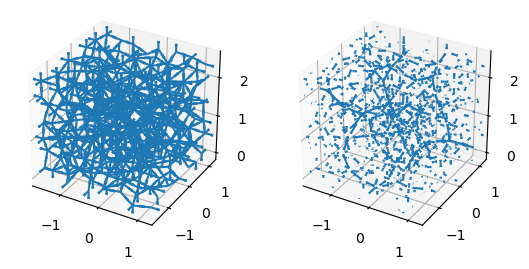

In [26]:
from Plotting import PlotContactVectorAndForce, GetAllContactpoints,AxesLimits
data = Rollout.GroundTruth[0]
BC = Rollout.BC_rollout[3]
fig,axs = PlotContactVectorAndForce(data,BC)
for ax in axs: AxesLimits(ax,BC)


In [27]:
data = Rollout.ML_rollout[0]
#data = Rollout.GroundTruth[0]

In [28]:
import pyvista as pv
from Plotting import ParticleMesh, GetAllContactpoints, GetContactPerParticle

gifname = "ML"
datalist = Rollout.ML_rollout[:5]
#datalist = Rollout.GroundTruth

plotter = pv.Plotter(notebook=False, off_screen=True)
spheremesh = pv.merge(ParticleMesh(datalist[0]))
plotter.add_mesh(spheremesh, color='lightblue', show_edges=False)

plotter.open_gif(f"{os.getcwd()}\\Figures\\compaction_{gifname}.gif",fps=7)

for data in tqdm(datalist):
    spheremesh.points = pv.merge(ParticleMesh(data)).points
    plotter.write_frame()

plotter.close()

 20%|██        | 1/5 [00:05<00:21,  5.30s/it]


KeyboardInterrupt: 

In [29]:
data.edge_index

tensor([[  0,   0,   0,  ..., 592, 593, 594],
        [  1,   3,   4,  ..., 398, 399, 399]])

In [31]:
data = Rollout.ML_rollout[4]
#data = Rollout.GroundTruth[4]
contactpoints = GetAllContactpoints(data)
ParContactPoints, ParContactNormals = GetContactPerParticle(data,contactpoints)
ParContactNormals[0],ParContactPoints[0]

([tensor([-0.9574, -0.2886, -0.0100]),
  tensor([ 0.1631, -0.9857, -0.0430]),
  tensor([ 0.9803, -0.1897, -0.0554]),
  tensor([-0.2986,  0.9542,  0.0186]),
  tensor([0.3588, 0.3785, 0.8533])],
 array([[-0.21955341,  0.03989512,  0.19314072],
        [ 0.01103478, -0.10250017,  0.18639347],
        [ 0.1671888 ,  0.06265328,  0.18447807],
        [-0.08324575,  0.29388094,  0.1989838 ],
        [ 0.0503921 ,  0.17610648,  0.36825985]], dtype=float32))

In [ ]:
import pyvista as pv
from Plotting import ParticleMesh, GetAllContactpoints, GetContactPerParticle,Plot3DVectors
data = Rollout.ML_rollout[4]
#data = Rollout.GroundTruth[4]
contactpoints = GetAllContactpoints(data)
ParContactPoints, ParContactNormals = GetContactPerParticle(data,contactpoints)

fig, ax = plt.subplots(1,1, subplot_kw={'projection': '3d'})
for i, (parcontactpoint, parcontactnormal) in enumerate(zip(ParContactPoints,ParContactNormals)):
    plotx, ploty, plotz = [parcontactpoint[:,dim] for dim in [0,1,2]]
    parcontactnormal.shape
    Plot3DVectors(ax,data.pos[i,:].resize(1,3),parcontactnormal,0)


In [ ]:
plotx, ploty, plotz = [contactpoints[:,dim] for dim in [0,1,2]]
fig, ax = plt.subplots(1,1, subplot_kw={'projection': '3d'})
ax.scatter(plotx,ploty,plotz,c='g')
contactpoints == data.pos[data.edge_index[0,:]]

In [ ]:
from Plotting import PlotXYZ
if dataset_name == "2Sphere": 
    PlotXYZ(Rollout,t_max=100)

In [ ]:
from Plotting import PlotGraph
for t in range(Rollout.timesteps):  
    #if t % 25 == 0: PlotGraph(Rollout.GroundTruth[t], plot_lines=True), print(t)

    if t % 20 == 0: PlotGraph(Rollout.ML_rollout[t], plot_lines=True)